In [65]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy.stats import norm, skew, randint

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (
    train_test_split, cross_val_score, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# Configuración de estilos y opciones
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', None)

# Habilitar gráficos en línea
%matplotlib inline


In [66]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [67]:
train.shape, test.shape


((1460, 81), (1459, 80))

In [68]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1. Identificadores y objetivo
- **Id**: Identificador único de cada vivienda.  
- **SalePrice**: Precio de venta de la propiedad (objetivo).  

## 2. Características de la parcela
- **MSSubClass**: Código de clase de construcción (tipo/estilo de vivienda).  
- **MSZoning**: Clasificación de zonificación (residencial, comercial, industrial, etc.).  
- **LotFrontage**: Metros lineales de calle conectados a la parcela.  
- **LotArea**: Superficie de la parcela en pies².  
- **Street**: Tipo de acceso vial (pavimentado o grava).  
- **Alley**: Tipo de acceso por callejón (pavimentado, grava o ninguno).  
- **LotShape**: Forma de la parcela (regular, ligeramente irregular, etc.).  
- **LandContour**: Planitud del terreno (nivel, pendiente, etc.).  
- **Utilities**: Disponibilidad de servicios (agua, alcantarillado, electricidad, gas).  
- **LotConfig**: Configuración de la parcela (interior, esquina, cul-de-sac, etc.).  
- **LandSlope**: Grado de inclinación del terreno (suave, moderado, severo).  

## 3. Ubicación y vecindario
- **Neighborhood**: Barrio o zona dentro de Ames.  
- **Condition1 / Condition2**: Proximidad a condiciones especiales (cerca de vías, parques, ferrocarriles).  

## 4. Tipo y estilo de la vivienda
- **BldgType**: Tipo de edificio (unifamiliar, dúplex, adosado, etc.).  
- **HouseStyle**: Estilo de la vivienda (1 planta, 1.5 plantas, 2 plantas, etc.).  

## 5. Calidad y condición general
- **OverallQual**: Calidad general de materiales y acabados (1 muy pobre – 10 excelente).  
- **OverallCond**: Estado general de la vivienda (1 muy pobre – 10 excelente).  

## 6. Fechas de construcción y remodelación
- **YearBuilt**: Año de construcción original.  
- **YearRemodAdd**: Año de la última remodelación o adición.  

## 7. Techo y exterior
- **RoofStyle**: Tipo de techo (a dos aguas, plano, cadera, etc.).  
- **RoofMatl**: Material del techo (teja, metal, etc.).  
- **Exterior1st / Exterior2nd**: Material de revestimiento exterior principal y secundario.  
- **MasVnrType**: Tipo de revestimiento de mampostería (ladrillo, piedra, ninguno).  
- **MasVnrArea**: Área de revestimiento de mampostería en pies².  
- **ExterQual / ExterCond**: Calidad y condición del material exterior.  

## 8. Sótano
- **Foundation**: Tipo de cimentación (losa, bloque, hormigón colado, etc.).  
- **BsmtQual / BsmtCond**: Calidad y condición del sótano.  
- **BsmtExposure**: Exposición del sótano a la luz (ninguna, mínima, media, buena).  
- **BsmtFinType1 / BsmtFinType2**: Tipo de acabado del sótano.  
- **BsmtFinSF1 / BsmtFinSF2**: Área terminada del sótano (dos tipos) en pies².  
- **BsmtUnfSF**: Área sin terminar del sótano en pies².  
- **TotalBsmtSF**: Área total del sótano en pies².  

## 9. Calefacción y electricidad
- **Heating / HeatingQC**: Tipo y calidad del sistema de calefacción.  
- **CentralAir**: Aire acondicionado central (Y/N).  
- **Electrical**: Tipo de sistema eléctrico (fusible, circuito, mixto).  

## 10. Área habitable y habitaciones
- **1stFlrSF / 2ndFlrSF**: Área de la primera y segunda planta en pies².  
- **LowQualFinSF**: Área terminada de baja calidad en pies².  
- **GrLivArea**: Área habitable sobre nivel del suelo en pies².  
- **FullBath / HalfBath**: Número de baños completos y medios baños.  
- **BsmtFullBath / BsmtHalfBath**: Baños en el sótano (completos y medios).  
- **BedroomAbvGr**: Número de dormitorios sobre el suelo.  
- **KitchenAbvGr**: Número de cocinas sobre el suelo.  
- **KitchenQual**: Calidad de la cocina.  
- **TotRmsAbvGrd**: Total de habitaciones sobre el suelo (sin incluir baños).  
- **Functional**: Funcionalidad de la vivienda (típica, mínimas/moderadas/serias deducciones).  

## 11. Chimeneas y garaje
- **Fireplaces**: Número de chimeneas.  
- **FireplaceQu**: Calidad de la chimenea.  
- **GarageType**: Ubicación del garaje (adjunto, independiente, sótano, etc.).  
- **GarageYrBlt**: Año de construcción del garaje.  
- **GarageFinish**: Nivel de acabado interior del garaje.  
- **GarageCars / GarageArea**: Capacidad en autos y área en pies² del garaje.  
- **GarageQual / GarageCond**: Calidad y condición del garaje.  

## 12. Porches, piscina y otras amenidades
- **PavedDrive**: Entrada pavimentada (Y, P, N).  
- **WoodDeckSF**: Área de terraza de madera en pies².  
- **OpenPorchSF / EnclosedPorch**: Área de porche abierto y cerrado en pies².  
- **3SsnPorch**: Área de porche de tres estaciones en pies².  
- **ScreenPorch**: Área de porche con mosquitero en pies².  
- **PoolArea / PoolQC**: Área de la piscina y calidad.  
- **Fence**: Calidad de la cerca (privacidad, madera, wire, ninguna).  
- **MiscFeature / MiscVal**: Característica miscelánea (elevador, cobertizo, etc.) y su valor.  

## 13. Venta
- **MoSold**: Mes de la venta (1–12).  
- **YrSold**: Año de la venta.  
- **SaleType**: Tipo de venta (convencional, efectivo, VA, contrato, etc.).  
- **SaleCondition**: Condición de la venta (normal, ejecución de hipoteca, familiar, etc.).  


In [69]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

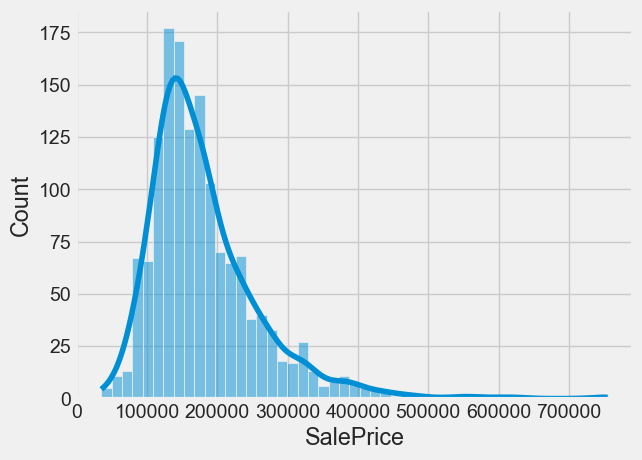

In [71]:
_ = sns.histplot(train.SalePrice, kde=True)

# valores sesgados, la media y la mediana son distintans el , cola larga a la derecha


## Skewness (Sesgo)  
- Mide la **asimetría** de la distribución.  
- **> 0**: cola derecha más larga (precios muy altos).  
- **< 0**: cola izquierda más larga (precios muy bajos).  
- Valores absolutos altos indican fuerte asimetría.

## Kurtosis (Curtosis)  
- Mide el **apuntamiento** y el peso de las colas.  
- **> 0**: pico más marcado y colas pesadas (más outliers).  
- **< 0**: pico más plano y colas ligeras (menos extremos).  
- Valores altos señalan muchos valores extremos.




In [72]:
#train=train.drop(["Id"], axis=1)
#test=test.drop(["Id"], axis=1)

In [73]:
#que tan sesgado es el precio de venta

print(f"Skewness: {train['SalePrice'].skew()}")
print(f"Kurtosis: {train['SalePrice'].kurt()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


# distribucion de variables numericas


In [74]:
list(set(train.dtypes.tolist()))
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [75]:
df_num.columns
var_num = df_num.columns.tolist()
print(var_num, len(var_num))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 38


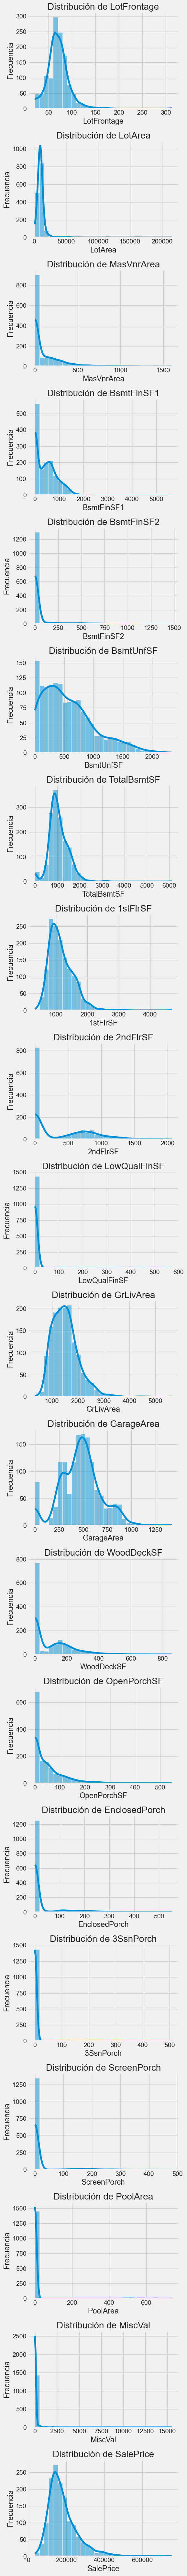

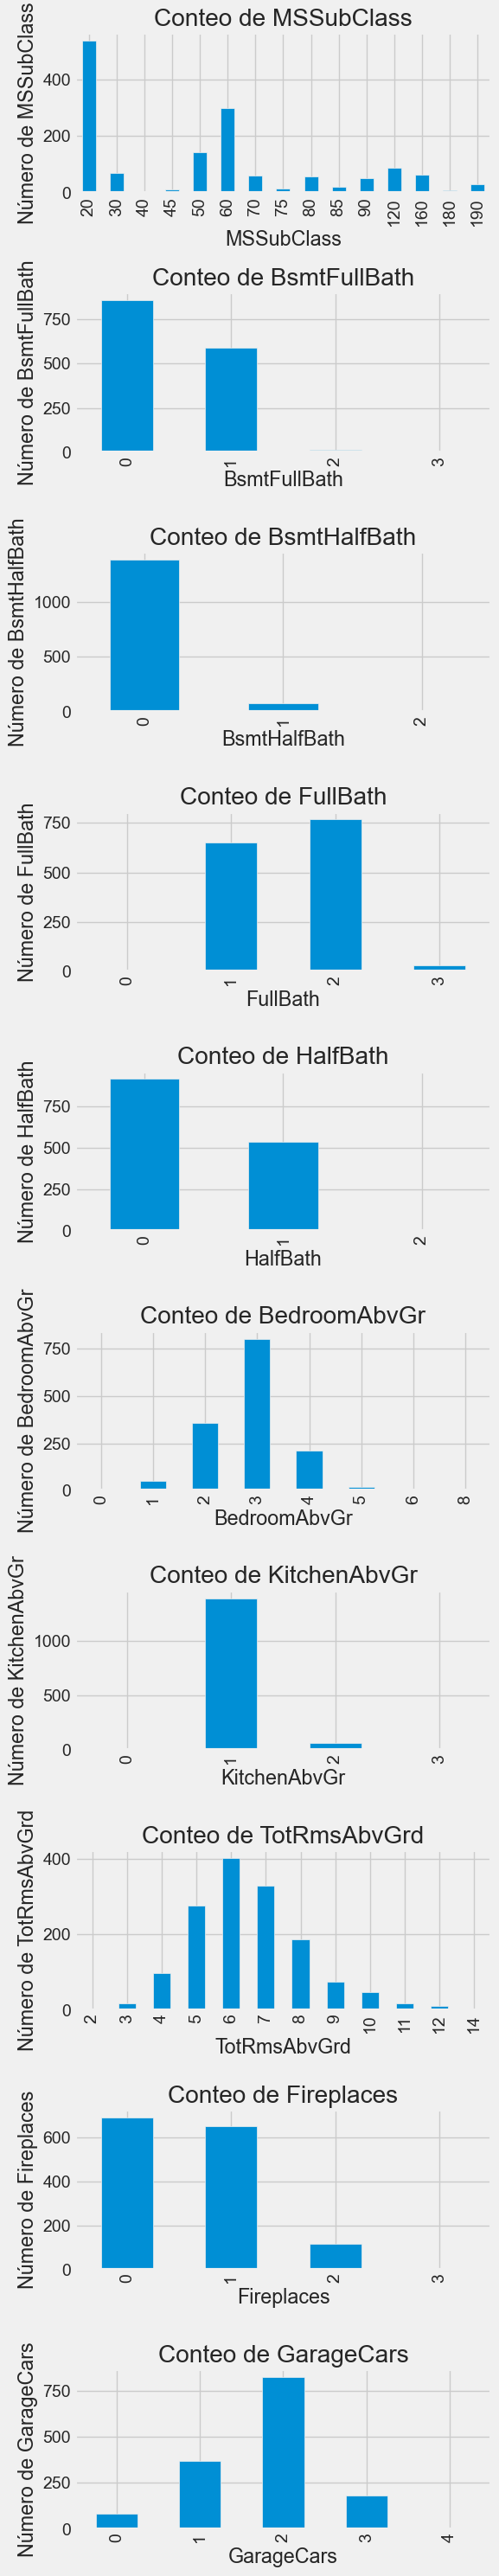

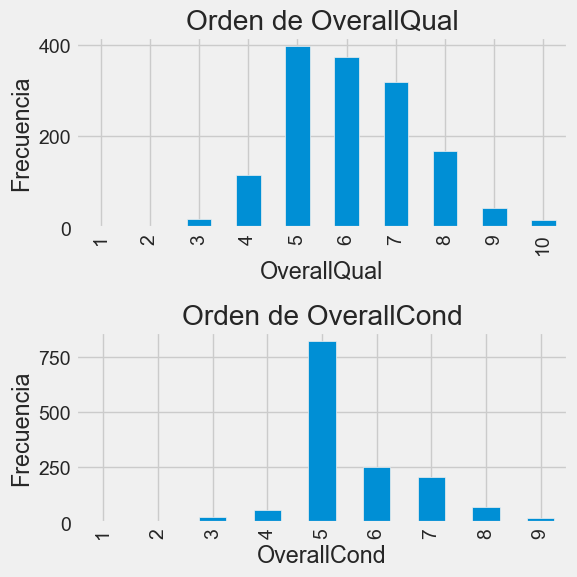

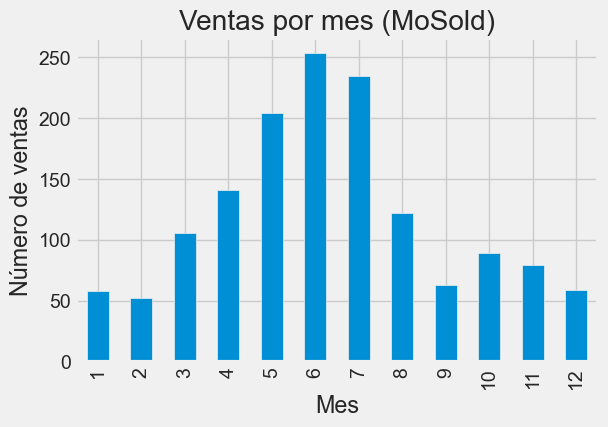

In [76]:

continuas = [
    'LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
    'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
    'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
    '3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice'
]

discretas = [
    'MSSubClass','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
    'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars'
]

ordinales = ['OverallQual','OverallCond']

ciclicas = ['MoSold']  # Mes de venta

# 2. Histogramas para continuas
fig, axs = plt.subplots(len(continuas), 1, figsize=(6, 4*len(continuas)))
for ax, var in zip(axs, continuas):
    sns.histplot(df_num[var].dropna(), kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
    
plt.tight_layout()
plt.show()

# 3. Barras para discretas
fig, axs = plt.subplots(len(discretas), 1, figsize=(6, 3*len(discretas)))
for ax, var in zip(axs, discretas):
    df_num[var].value_counts().sort_index().plot(kind='bar', ax=ax)
    ax.set_title(f'Conteo de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel(f'Número de {var}')
plt.tight_layout()
plt.show()

# 4. Barras ordenadas para ordinales
fig, axs = plt.subplots(len(ordinales), 1, figsize=(6, 3*len(ordinales)))
for ax, var in zip(axs, ordinales):
    df_num[var].value_counts().sort_index().plot(kind='bar', ax=ax)
    ax.set_title(f'Orden de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# 5. Mes de venta (cíclica)
plt.figure(figsize=(6,4))
df_num['MoSold'].value_counts().sort_index().plot(kind='bar')
plt.title('Ventas por mes (MoSold)')
plt.xlabel('Mes')
plt.ylabel('Número de ventas')
plt.show()


# <span style="color:green;">Colinealidad</span>


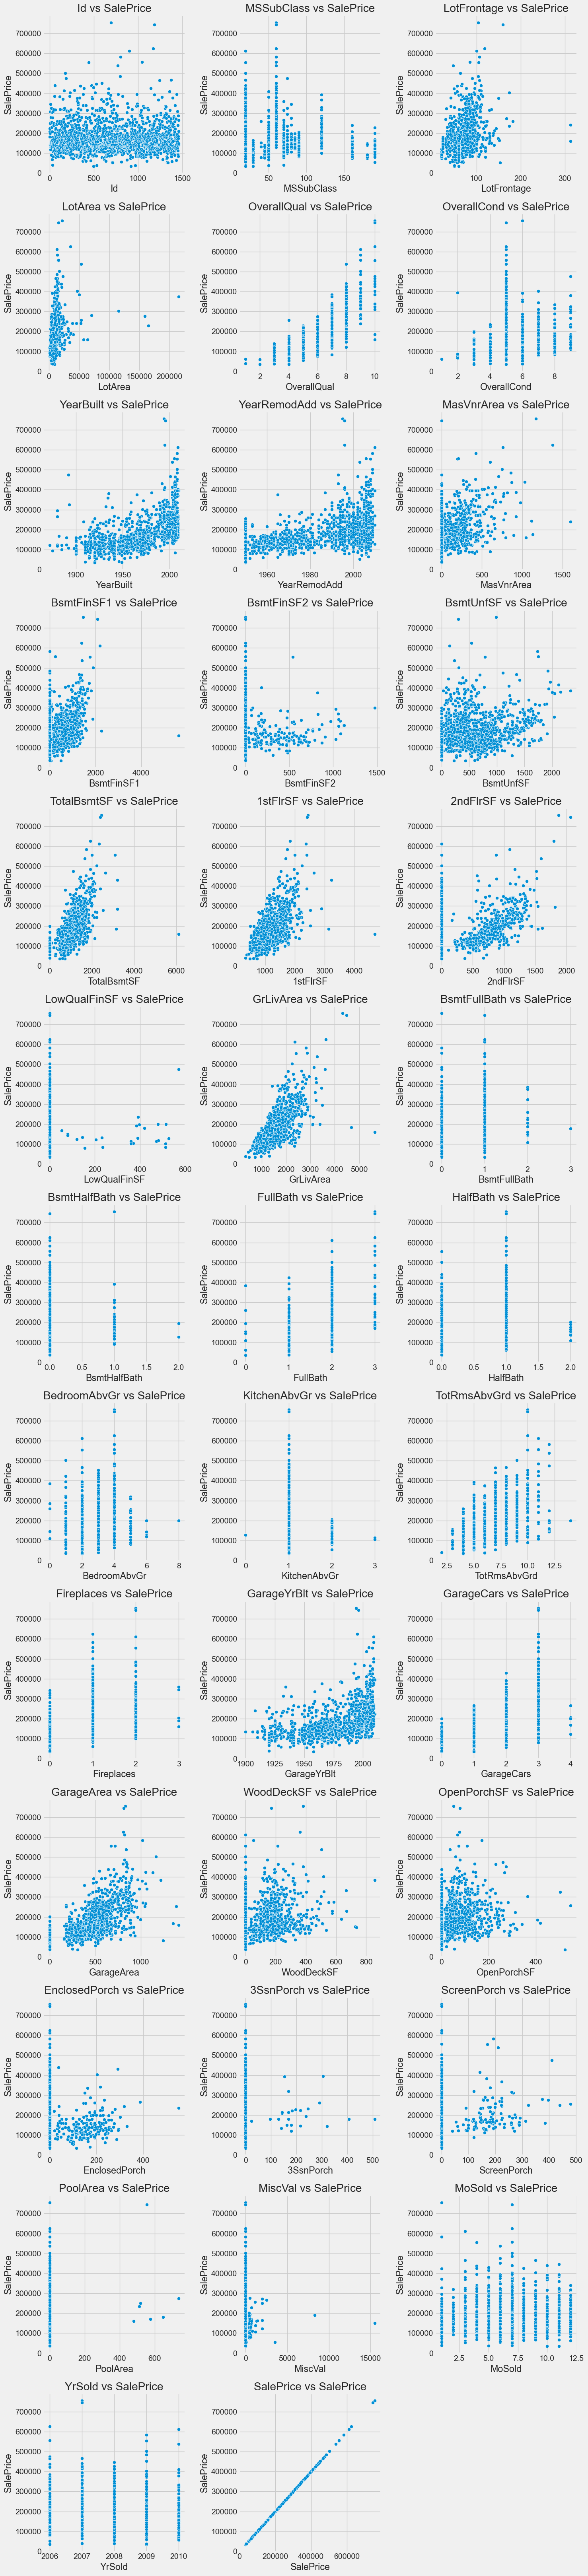

In [77]:
# scatterplot de var_num vs SalePrice con 3 columnas
n_cols = 3
n_rows = (len(var_num) + n_cols - 1) // n_cols  # Calcular el número de filas necesarias

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajustar el tamaño de la figura
axs = axs.flatten()  # Aplanar los ejes para iterar fácilmente

for ax, var in zip(axs, var_num):
    sns.scatterplot(x=train[var], y=train['SalePrice'], ax=ax)
    ax.set_title(f'{var} vs SalePrice')
    ax.set_xlabel(var)
    ax.set_ylabel('SalePrice')

# Eliminar los subplots vacíos si hay más subplots que variables
for ax in axs[len(var_num):]:
    ax.remove()

plt.tight_layout()
plt.show()


## Observaciones de los scatter plots  

- **LotFrontage vs SalePrice**  
  - Se ve cierta nube dispersa sin una tendencia muy clara.  
  - Correlación débil; puede haber otros factores influyendo más fuertemente.

- **YearBuilt vs SalePrice**  
  - Aparece una ligera inclinación positiva: las casas más nuevas tienden a venderse más caro.  
  - Pero la nube de puntos es amplia, indicando que la edad sola no explica todo el precio.

- **TotalBsmtSF vs SalePrice**  
  - La relación parece creciente, quizá no completamente lineal.  

- **1stFlrSF vs SalePrice**  
  - Tendencia al alza parecida a TotalBsmtSF: más área planta baja → precio mayor.  
  - Explora ajuste lineal vs polinómico para ver qué encaja mejor.

- **2ndFlrSF vs SalePrice**  
  - Poca densidad de puntos (muchas casas no tienen segunda planta), pero también hay una tendencia creciente.  
  - Quizá un modelo que trate los ceros por separado o use transformación log.

- **GrLivArea vs SalePrice**  
  - Relación claramente lineal y fuerte: más área habitable → mayor precio.  
  - Buen candidato para modelo lineal directo o con ligera transformación.

## Exploraremos esta correlaciones



In [78]:
corr_matrix = train[var_num].corr()
print(corr_matrix['SalePrice'].sort_values(ascending=False))


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

## Interpretación de la correlación con SalePrice

- **Fuerza de la relación lineal**  
  - **|r| ≥ 0.7**: relación fuerte  
    - `OverallQual` (0.79), `GrLivArea` (0.71)  
  - **0.4 ≤ |r| < 0.7**: relación moderada  
    - `GarageCars` (0.64), `GarageArea` (0.62), `TotalBsmtSF` (0.61), `1stFlrSF` (0.61), `FullBath` (0.56), etc.  
  - **0.2 ≤ |r| < 0.4**: relación débil  
    - `BsmtFinSF1` (0.39), `LotFrontage` (0.35), `WoodDeckSF` (0.32), etc.  
  - **|r| < 0.2**: casi sin relación lineal  
    - `ScreenPorch`, `PoolArea`, `MoSold`,

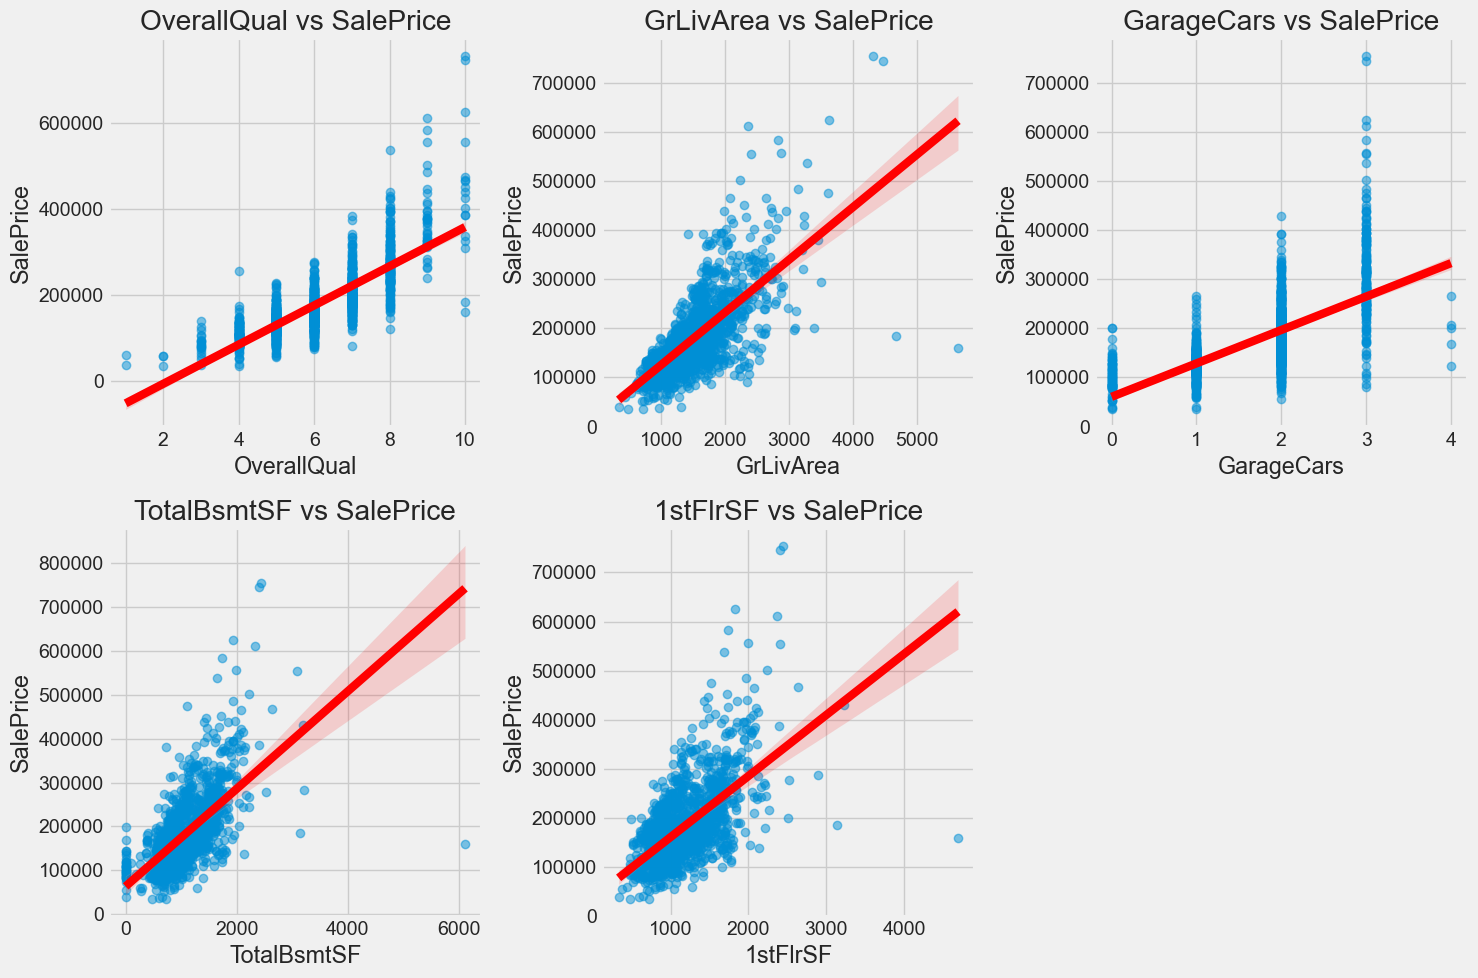

In [79]:
top_vars = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']
n_cols = 3
n_rows = (len(top_vars) + n_cols - 1) // n_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size
axs = axs.flatten()  # Flatten the axes array for easy iteration

for ax, var in zip(axs, top_vars):
    sns.regplot(x=var, y='SalePrice', data=train, 
                scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ax=ax)
    ax.set_title(f'{var} vs SalePrice')
    ax.set_xlabel(var)
    ax.set_ylabel('SalePrice')

# Remove empty subplots if there are more subplots than variables
for ax in axs[len(top_vars):]:
    ax.remove()

plt.tight_layout()
plt.show()


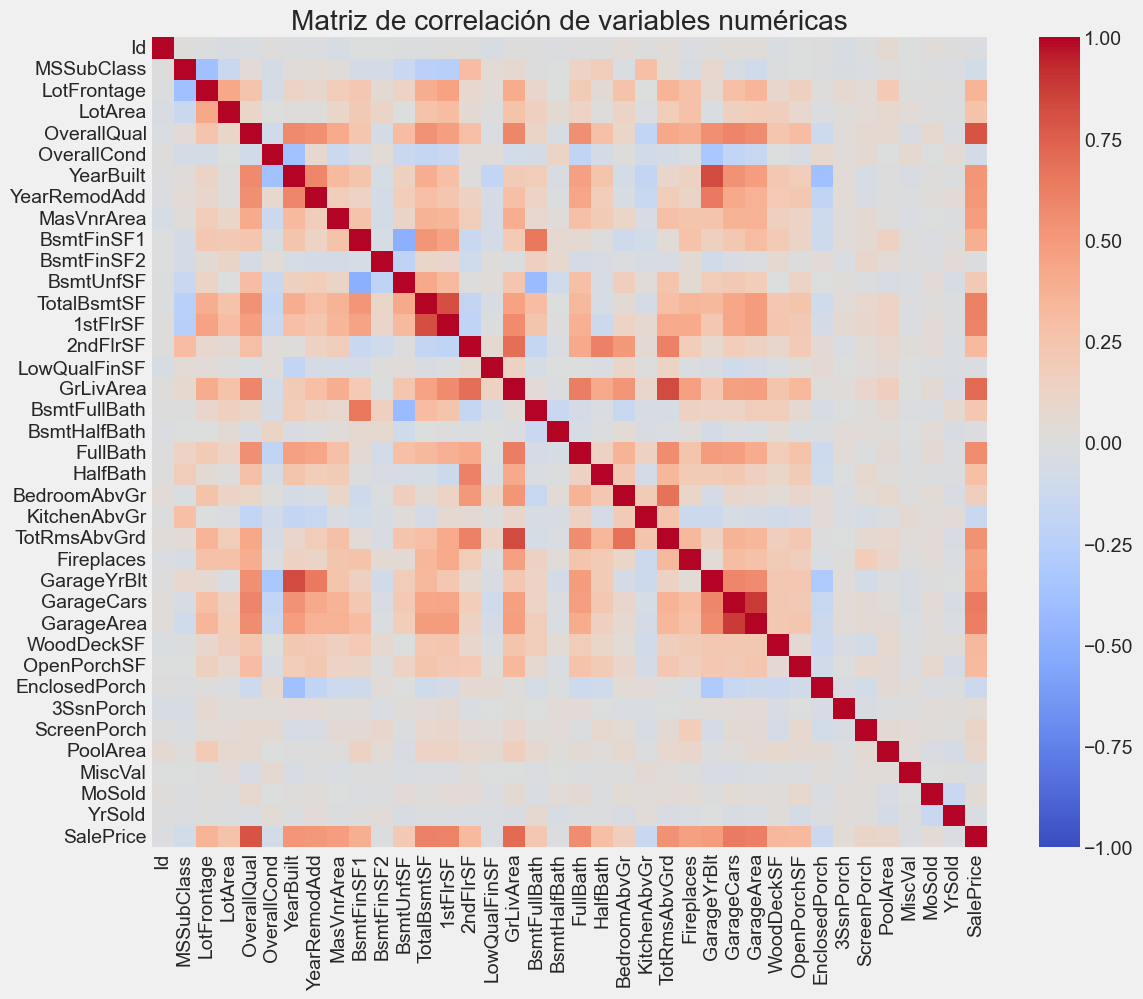

Pares con |correlación| ≥ 0.8:
YearBuilt ↔ GarageYrBlt: 0.83
TotalBsmtSF ↔ 1stFlrSF: 0.82
GrLivArea ↔ TotRmsAbvGrd: 0.83
GarageCars ↔ GarageArea: 0.88


In [80]:

# Calcula la matriz de correlación solo de var_num (numéricas, incluyendo SalePrice)
corr = train[var_num].corr()

# Opcional: filtrar para mostrar solo correlaciones fuertes
strong_corr = corr[(corr.abs() >= 0.8) & (corr.abs() < 1.0)]

# Dibuja el heatmap completo
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación de variables numéricas')
plt.show()

# Si quieres ver solo pares con alta colinealidad:
print("Pares con |correlación| ≥ 0.8:")
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) >= 0.8:
            print(f"{corr.index[i]} ↔ {corr.columns[j]}: {corr.iloc[i,j]:.2f}")


## Estrategias para reducir colinealidad

1. **Eliminar una de cada par**  
   - Elige quedarte con la variable que tenga **mayor correlación con SalePrice**.  
   - Ejemplo: si `GrLivArea` (0.71) correlaciona más fuerte con `SalePrice` que `TotRmsAbvGrd` (0.53), droppea `TotRmsAbvGrd`.

2. **Usar VIF (Variance Inflation Factor)**  
   - Calcula VIF para cuantificar la multicolinealidad en tu conjunto. Variables con VIF > 5 (o 10) son candidatas a eliminar.




In [81]:

# 1. Pares fuertes detectados
# 1. Detectar pares fuertes (ya lo tienes)
pairs = [
    ('YearBuilt', 'GarageYrBlt'),
    ('TotalBsmtSF', '1stFlrSF'),
    ('GrLivArea', 'TotRmsAbvGrd'),
    ('GarageCars', 'GarageArea')
]

# 2. Calcular correlación con SalePrice
corr_with_target = train[var_num].corr()['SalePrice']

# 3. Elegir qué columnas eliminar
to_drop = []
for a, b in pairs:
    if abs(corr_with_target[a]) > abs(corr_with_target[b]):
        to_drop.append(b)
    else:
        to_drop.append(a)

print("Columnas a eliminar por colinealidad:", to_drop)



Columnas a eliminar por colinealidad: ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


In [82]:
# Lista de características (columnas) que tienen valores nulos en el conjunto de datos 'train'
features_with_na = [features for features in train.columns if train[features].isnull().sum() >= 1]

# Crear un DataFrame que contenga información sobre las características con valores nulos
a = pd.DataFrame({
    'features': features_with_na,  # Nombres de las características con valores nulos
    'Total': [train[i].isnull().sum() for i in features_with_na],  # Total de valores nulos por característica
    'Missing_PCT': [np.round(train[i].isnull().sum() / train.shape[0], 4) for i in features_with_na]  # Porcentaje de valores nulos
}).sort_values(by='Missing_PCT', ascending=False).reset_index(drop=True)  # Ordenar por porcentaje de valores nulos en orden descendente y reiniciar el índice

# Aplicar un estilo de gradiente de color para resaltar visualmente los valores en el DataFrame
a.style.background_gradient(cmap='Reds') 

# la primera columna features es la que tiene el nombre de la variable, la segunda columna Total es el total de valores nulos y la tercera columna Missing_PCT es el porcentaje de valores nulos.

,features,Total,Missing_PCT
0,PoolQC,1453,0.995200
1,MiscFeature,1406,0.963000
2,Alley,1369,0.937700
3,Fence,1179,0.807500
4,MasVnrType,872,0.597300
5,FireplaceQu,690,0.472600
6,LotFrontage,259,0.177400
7,GarageType,81,0.055500
8,GarageYrBlt,81,0.055500
9,GarageFinish,81,0.055500


# PREPARACIÓN DE DATOS

*DATA PREPARATION*

# Plan de Preparación de Datos

## 1. Limpieza Inicial  
- **Eliminar columnas con >80% de valores faltantes**  
  - PoolQC, MiscFeature, Alley, Fence  
- **Eliminar variables colineales**  
  - `GarageYrBlt`, `1stFlrSF`, `TotRmsAbvGrd`, `GarageArea`

## 2. Imputación de Valores Faltantes  
- **Numéricas**: estrategia **mediana**  
- **Categorías “ausencia”** (piscina, garaje, chimenea…) → rellenar con **"None"** o **0**  
- **LotFrontage**: imputar mediana global o por barrio  
- **Electrical**: rellenar con la **moda**

## 3. Ingeniería de Características  
- **Transformaciones de escala**: log( x + 1 ) en variables muy sesgadas  
- **Fechas**: crear  
  - `HouseAge` = YrSold – YearBuilt  
  - `SinceRemod` = YrSold – YearRemodAdd  
  - `GarageAge` = YrSold – GarageYrBlt  
- **Mes cíclico**:  
  ```python
  MoSin = sin(2π·MoSold/12)
  MoCos = cos(2π·MoSold/12)


In [83]:
# 0) Definimos las columnas a eliminar:
drop_cols = [
    'Id',
    # Colinealidad (menor correlación con SalePrice)
    'GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea',
    # missing > 80%
    'PoolQC', 'MiscFeature', 'Alley', 'Fence'
]

# 1) Listas de variables (ya sin las eliminadas)
# continuas
cont_vars = [
    'LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
    'BsmtUnfSF','TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea',
    'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
    'ScreenPorch','PoolArea','MiscVal'
]
# discretas
disc_vars = [
    'MSSubClass','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
    'BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageCars'
]
# ordinales
ord_vars = [
    'ExterQual','ExterCond',
    'BsmtQual','BsmtCond','HeatingQC','KitchenQual',
    'FireplaceQu','GarageQual','GarageCond','PoolQC','Fence','Functional'
]
# ordinales numericas
ord_num_vars = ['OverallQual','OverallCond']

# fechas
date_vars = ['YearBuilt','YearRemodAdd','YrSold']
mes_vars  = ['MoSold']
# categóricas
cat_vars = [
    'MSZoning','Street','Utilities','LotConfig','LandSlope','Neighborhood',
    'Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
    'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
    'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
    'CentralAir','Electrical','GarageType','GarageFinish',
    'SaleType','SaleCondition'
]



# Tipos de Variables

| Tipo                    | Descripción                                                                                           |
| ----------------------- | ----------------------------------------------------------------------------------------------------- |
| **Continuas**           | Variables cuantitativas con infinitos valores posibles (ej. áreas, precios).                          |
| **Discretas / Conteo**  | Enteros que representan conteos o categorías codificadas numéricamente (ej. número de baños, clases). |
| **Ordinales**           | Categóricas con orden natural (ej. calidad: “Po” < “Fa” < … < “Ex”).                                  |
| **Ordinales numéricas** | Enteros con orden (ej. `OverallQual`, `OverallCond` en escala 1–10).                                  |
| **Nominales**           | Categóricas sin orden (ej. vecindario, tipo de techo).                                                |
| **Fechas**              | Años o tiempos absolutos (ej. `YearBuilt`).                                                           |
| **Cíclicas**            | Variables periódicas (ej. mes del año: 1–12; requieren sine/cosine).                                  |




---

### 📊 Recomendaciones de Escalado por Tipo de Variable y Tipo de Modelo

| Tipo de Variable               | Ejemplos                                                 | ¿Escalar? en Regresión / SVM / KNN / Redes  | ¿Escalar? en Árboles / RandomForest / XGBoost        |
| ------------------------------ | -------------------------------------------------------- | ------------------------------------------- | ---------------------------------------------------- |
| **Numéricas continuas**        | `LotArea`, `GrLivArea`, `TotalBsmtSF`, etc.              | ✅ Sí (obligatorio o muy recomendable)       | ❌ No necesario                                       |
| **Numéricas discretas**        | `FullBath`, `GarageCars`, `BedroomAbvGr`, etc.           | ✅ Sí (recomendado, tratadas como numéricas) | ❌ No necesario                                       |
| **Ordinales categóricas**      | `ExterQual`, `BsmtQual`, `KitchenQual`, etc.             | ✅ Sí (recomendado)                          | ❌ No necesario                                       |
| **Ordinales numéricas**        | `OverallQual`, `OverallCond`                             | ✅ Sí (recomendado)                          | ❌ No necesario                                       |
| **Categóricas nominales**      | `Neighborhood`, `HouseStyle`, `RoofStyle`, etc.          | ❌ No (OneHot ya las convierte bien)         | ❌ No                                                 |
| **Fechas**                     | `YearBuilt`, `YrSold`, `MoSold`                          | 🔥 Depende: a veces útil escalar `Year`     | ❌ Normalmente se descartan o agrupan                 |
| **Columnas con mucho missing** | `PoolQC`, `Fence`, `MiscFeature` (cuando no se eliminan) | ⚠️ Imputar o codificar NA con cuidado       | ⚠️ Igual: árboles pueden manejar `NA` como categoría |

---

### 🧠 ¿Cómo usar esto?

Cuando quieras probar modelos:

* **Regresivos o basados en distancia (Ridge, Lasso, KNN, SVM, redes):**

  * Escala: `numéricas`, `discretas`, `ordinales categóricas`, `ordinales numéricas`.
  * No escales: `categóricas nominales` (OneHot ya sirve), fechas (salvo casos especiales).

* **Basados en árboles (DecisionTree, RandomForest, XGBoost):**

  * ❌ No escales nada.
  * ✅ Solo codifica ordinales y usa OneHot para nominales.

---


In [84]:
# Lista básica de niveles de calidad (Po < Fa < TA < Gd < Ex)
qual = ['Po','Fa','TA','Gd','Ex']

# Lista básica de niveles con NA permitido
qual_na = ['NA','Po','Fa','TA','Gd','Ex']

# Niveles de PoolQC
pool = ['NA','Fa','TA','Gd','Ex']

# Niveles de Fence
fence = ['NA','MnWw','MnPrv','GdWo','GdPrv']

# Niveles de Functional
func = ['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal']

ord_categories = [
    qual,     # ExterQual
    qual,     # ExterCond
    qual_na,  # BsmtQual
    qual_na,  # BsmtCond
    qual,     # HeatingQC
    qual,     # KitchenQual
    qual_na,  # FireplaceQu
    qual_na,  # GarageQual
    qual_na,  # GarageCond
    pool,     # PoolQC
    fence,    # Fence
    func      # Functional
]


Hecho, Andrés. Primero una explicación sencilla, luego un bloque en Markdown:

---

**¿Por qué definimos estas listas de niveles (`qual`, `qual_na`, `pool`, `fence`, `func`)?**

1. **Ordinalidad real**
   Esas variables (`ExterQual`, `BsmtCond`, `PoolQC`, etc.) no son nominales sino **ordinales**: sus categorías tienen un orden lógico (pobre → excelente).

2. **Control explícito del orden**
   Al pasarle a `OrdinalEncoder` nuestra propia lista de niveles, le decimos exactamente cómo transformar cada etiqueta en un número (0, 1, 2 …).

   * Por ejemplo, `TA` (Typical) será siempre `2`, porque en `['Po','Fa','TA','Gd','Ex']` ocupa la posición 2.

3. **Coherencia Train/Test**
   Si en tu set de prueba aparece una categoría nueva o, por ejemplo, no todas las categorías están presentes, el encoder mantendrá el mismo mapeo y asignará **–1** a lo desconocido, evitando errores.

4. **Diferentes dominios de categorías**
   No todas las ordinales tienen el mismo conjunto de niveles:

   * `PoolQC` nunca tiene “Ex”, pero sí “NA” (sin piscina).
   * `Fence` usa niveles como `MnWw` (madera mínima), `GdPrv` (privacidad buena).
   * `Functional` tiene su propia jerarquía de funcionamiento.

5. **Evitar ambigüedades**
   Si no defines estas listas, el `OrdinalEncoder` ordenaría alfabéticamente (`Ex`, `Fa`, `Gd`, …), que **no coincide** con el orden lógico de calidad.

---

## ¿Por qué es importante?

* **Orden lógico**: convierte etiquetas cualitativas en números respetando su jerarquía.
* **Consistencia**: el mismo mapeo en entrenamiento y prueba, incluso si faltan categorías.
* **Control de valores nuevos**: `unknown_value=-1` marca cualquier etiqueta inesperada, evitando fallos.
* **Evita el orden alfabético** por defecto, que no tiene sentido para calidad ni funcionalidad.

Con este enfoque, tu modelo recibirá **variables ordinales transformadas correctamente**, mejorando su capacidad de aprendizaje y evitando errores de codificación.


In [85]:
# def drop_columns(X):
#     return X.drop(columns=drop_cols)

# dropper = FunctionTransformer(drop_columns, validate=False) #usamos una funcion en lugar de una funcion lambda porque no se puede usar en ColumnTransformer

# 3) Pipelines de preprocesamiento
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

disc_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # (opcional) + scaler si lo deseas
    ('scaler',  StandardScaler())
])
# Ordinal pipeline CON escalado (para Ridge, Lasso)
ord_pipe_scaled = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=ord_categories,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
    ('scaler', StandardScaler())
])

ord_pipe_noscale = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=ord_categories,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])






cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

def build_preprocessor(ord_pipe):
    return ColumnTransformer([
        ('drop', 'drop',           drop_cols),
        ('num',  num_pipe,          cont_vars + ord_num_vars),
        ('disc', disc_pipe,         disc_vars),
        ('ord',  ord_pipe,          ord_vars),
        ('cat',  cat_pipe,          cat_vars),
        ('date', 'drop',            date_vars),
        ('mes',  'drop',            mes_vars)
    ], remainder='drop')

# def build_preprocessor(ord_pipe):
#     return ColumnTransformer([
#         ('drop', dropper,           drop_cols),
#         ('num',  num_pipe,          cont_vars + ord_num_vars),
#         ('disc', disc_pipe,         disc_vars),
#         ('ord',  ord_pipe,          ord_vars),
#         ('cat',  cat_pipe,          cat_vars),
#         ('date', 'drop',            date_vars),
#         ('mes',  'drop',            mes_vars)
#     ], remainder='drop')

preprocessor_scaled = build_preprocessor(ord_pipe_scaled)     # Para modelos lineales
preprocessor_noscale = build_preprocessor(ord_pipe_noscale)   # Para árboles



# Descripción del Pipeline de Preprocesamiento

A continuación se detalla cada paso de nuestro pipeline, qué hace y por qué lo hacemos:

---

## 0) Eliminación de columnas (`dropper`)


* **Objetivo**: Quitar variables que no aportan o pueden perjudicar el modelo.
* **Columnas eliminadas**:

  * `Id`: identificador irrelevante para la predicción.
  * Variables colineales (`GarageYrBlt`, `1stFlrSF`, `TotRmsAbvGrd`, `GarageArea`) para evitar redundancia.
  * Columnas con > 80 % de nulos (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) para no imputar información prácticamente inexistente.

---

## 1) Pipeline de variables continuas (`num_pipe`)



* **Imputer(strategy='median')**

  * Rellena valores faltantes con la **mediana** de la variable.
  * Robusto frente a valores extremos.

* **StandardScaler()**

  * Centra en 0 y escala a desviación 1:
    $x_{\text{scaled}} = \frac{x - \mu}{\sigma}$
  * Asegura que las variables numéricas estén en la misma escala para modelos sensibles.

---

## 2) Pipeline de variables de conteo/discretas (`disc_pipe`)



* **Imputación con mediana**: las discretas también pueden tener nulos.
* **Escalado**: opcional, pero ayuda a homogeneizar rangos si se combinan con otras numéricas.

---

## 3) Pipeline de variables ordinales categóricas (`ord_pipe`)


* **Imputer(strategy='most\_frequent')**

  * Rellena nulos con la categoría más frecuente (“moda”).

* **OrdinalEncoder**

  * Convierte niveles (p. ej. `['Po','Fa','TA','Gd','Ex']`) en enteros respetando su orden.
  * `handle_unknown='use_encoded_value', unknown_value=-1` → cualquier categoría nueva en test queda codificada como –1.

---

## 4) Pipeline de variables categóricas nominales (`cat_pipe`)



* **Imputer(constant, fill\_value='Missing')**

  * Rellena nulos con la etiqueta `"Missing"` para tratarlos como categoría más.

* **OneHotEncoder**

  * Crea variables binarias para cada nivel.
  * `handle_unknown='ignore'` → nuevas categorías en test se omiten sin error.

---
Perfecto, Andrés. Ya tienes un excelente resumen en tu markdown. Ahora te ayudo a completar la parte que falta: **la función `build_preprocessor()`**, que permite crear el `ColumnTransformer` completo a partir del `ord_pipe` (con o sin escalado).

Puedes añadir esta sección al final de tu markdown así:

---

## 5) Función para construir el preprocesador (`build_preprocessor`)

Creamos una función reutilizable que permite construir el `ColumnTransformer` completo. Esto es útil porque, para ciertos modelos como `Ridge` o `Lasso`, queremos aplicar escalado a las variables ordinales, mientras que para modelos como `RandomForest` o `DecisionTree` no es necesario.




In [86]:
# dividir el df
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [87]:
# 1) Activa la salida en pandas
preprocessor_scaled.set_output(transform="pandas")

# 2) Ajusta y transforma X_train
X_train_df = preprocessor_scaled.fit_transform(X_train)

# 3) Explora de forma natural
print(X_train_df.shape)
display(X_train_df.head())       # ver primeras filas
print(X_train_df.columns.tolist())  # ver lista de columnas
print(X_train_df.dtypes)       # ver tipos de datos

(1168, 224)


,num__LotFrontage,num__LotArea,num__MasVnrArea,num__BsmtFinSF1,num__BsmtFinSF2,num__BsmtUnfSF,num__TotalBsmtSF,num__2ndFlrSF,num__LowQualFinSF,num__GrLivArea,num__WoodDeckSF,num__OpenPorchSF,num__EnclosedPorch,num__3SsnPorch,num__ScreenPorch,num__PoolArea,num__MiscVal,num__OverallQual,num__OverallCond,disc__MSSubClass,disc__BsmtFullBath,disc__BsmtHalfBath,disc__FullBath,disc__HalfBath,disc__BedroomAbvGr,disc__KitchenAbvGr,disc__Fireplaces,disc__GarageCars,ord__ExterQual,ord__ExterCond,ord__BsmtQual,ord__BsmtCond,ord__HeatingQC,ord__KitchenQual,ord__FireplaceQu,ord__GarageQual,ord__GarageCond,ord__PoolQC,ord__Fence,ord__Functional,cat__MSZoning_C (all),cat__MSZoning_FV,cat__MSZoning_RH,cat__MSZoning_RL,cat__MSZoning_RM,cat__Street_Grvl,cat__Street_Pave,cat__Utilities_AllPub,cat__Utilities_NoSeWa,cat__LotConfig_Corner,cat__LotConfig_CulDSac,cat__LotConfig_FR2,cat__LotConfig_FR3,cat__LotConfig_Inside,cat__LandSlope_Gtl,cat__LandSlope_Mod,cat__LandSlope_Sev,cat__Neighborhood_Blmngtn,cat__Neighborhood_Blueste,cat__Neighborhood_BrDale,cat__Neighborhood_BrkSide,cat__Neighborhood_ClearCr,cat__Neighborhood_CollgCr,cat__Neighborhood_Crawfor,cat__Neighborhood_Edwards,cat__Neighborhood_Gilbert,cat__Neighborhood_IDOTRR,cat__Neighborhood_MeadowV,cat__Neighborhood_Mitchel,cat__Neighborhood_NAmes,cat__Neighborhood_NPkVill,cat__Neighborhood_NWAmes,cat__Neighborhood_NoRidge,cat__Neighborhood_NridgHt,cat__Neighborhood_OldTown,cat__Neighborhood_SWISU,cat__Neighborhood_Sawyer,cat__Neighborhood_SawyerW,cat__Neighborhood_Somerst,cat__Neighborhood_StoneBr,cat__Neighborhood_Timber,cat__Neighborhood_Veenker,cat__Condition1_Artery,cat__Condition1_Feedr,cat__Condition1_Norm,cat__Condition1_PosA,cat__Condition1_PosN,cat__Condition1_RRAe,cat__Condition1_RRAn,cat__Condition1_RRNe,cat__Condition1_RRNn,cat__Condition2_Artery,cat__Condition2_Feedr,cat__Condition2_Norm,cat__Condition2_PosA,cat__Condition2_PosN,cat__Condition2_RRAe,cat__Condition2_RRAn,cat__Condition2_RRNn,cat__BldgType_1Fam,cat__BldgType_2fmCon,cat__BldgType_Duplex,cat__BldgType_Twnhs,cat__BldgType_TwnhsE,cat__HouseStyle_1.5Fin,cat__HouseStyle_1.5Unf,cat__HouseStyle_1Story,cat__HouseStyle_2.5Fin,cat__HouseStyle_2.5Unf,cat__HouseStyle_2Story,cat__HouseStyle_SFoyer,cat__HouseStyle_SLvl,cat__RoofStyle_Flat,cat__RoofStyle_Gable,cat__RoofStyle_Gambrel,cat__RoofStyle_Hip,cat__RoofStyle_Mansard,cat__RoofStyle_Shed,cat__RoofMatl_ClyTile,cat__RoofMatl_CompShg,cat__RoofMatl_Metal,cat__RoofMatl_Roll,cat__RoofMatl_Tar&Grv,cat__RoofMatl_WdShake,cat__RoofMatl_WdShngl,cat__Exterior1st_AsbShng,cat__Exterior1st_AsphShn,cat__Exterior1st_BrkComm,cat__Exterior1st_BrkFace,cat__Exterior1st_CBlock,cat__Exterior1st_CemntBd,cat__Exterior1st_HdBoard,cat__Exterior1st_ImStucc,cat__Exterior1st_MetalSd,cat__Exterior1st_Plywood,cat__Exterior1st_Stone,cat__Exterior1st_Stucco,cat__Exterior1st_VinylSd,cat__Exterior1st_Wd Sdng,cat__Exterior1st_WdShing,cat__Exterior2nd_AsbShng,cat__Exterior2nd_AsphShn,cat__Exterior2nd_Brk Cmn,cat__Exterior2nd_BrkFace,cat__Exterior2nd_CBlock,cat__Exterior2nd_CmentBd,cat__Exterior2nd_HdBoard,cat__Exterior2nd_ImStucc,cat__Exterior2nd_MetalSd,cat__Exterior2nd_Other,cat__Exterior2nd_Plywood,cat__Exterior2nd_Stone,cat__Exterior2nd_Stucco,cat__Exterior2nd_VinylSd,cat__Exterior2nd_Wd Sdng,cat__Exterior2nd_Wd Shng,cat__MasVnrType_BrkCmn,cat__MasVnrType_BrkFace,cat__MasVnrType_Missing,cat__MasVnrType_Stone,cat__Foundation_BrkTil,cat__Foundation_CBlock,cat__Foundation_PConc,cat__Foundation_Slab,cat__Foundation_Stone,cat__Foundation_Wood,cat__BsmtExposure_Av,cat__BsmtExposure_Gd,cat__BsmtExposure_Missing,cat__BsmtExposure_Mn,cat__BsmtExposure_No,cat__BsmtFinType1_ALQ,cat__BsmtFinType1_BLQ,cat__BsmtFinType1_GLQ,cat__BsmtFinType1_LwQ,cat__BsmtFinType1_Missing,cat__BsmtFinType1_Rec,cat__BsmtFinType1_Unf,cat__BsmtFinType2_ALQ,cat__BsmtFinType2_BLQ,cat__BsmtFinType2_GLQ,cat__BsmtFinType2_LwQ,cat__BsmtFinType2_Missing,cat__BsmtFinType2_Rec,cat__BsmtFinType2_Unf,cat__Heating_Floor,cat__Heating_GasA,cat__Heating_Gas

['num__LotFrontage', 'num__LotArea', 'num__MasVnrArea', 'num__BsmtFinSF1', 'num__BsmtFinSF2', 'num__BsmtUnfSF', 'num__TotalBsmtSF', 'num__2ndFlrSF', 'num__LowQualFinSF', 'num__GrLivArea', 'num__WoodDeckSF', 'num__OpenPorchSF', 'num__EnclosedPorch', 'num__3SsnPorch', 'num__ScreenPorch', 'num__PoolArea', 'num__MiscVal', 'num__OverallQual', 'num__OverallCond', 'disc__MSSubClass', 'disc__BsmtFullBath', 'disc__BsmtHalfBath', 'disc__FullBath', 'disc__HalfBath', 'disc__BedroomAbvGr', 'disc__KitchenAbvGr', 'disc__Fireplaces', 'disc__GarageCars', 'ord__ExterQual', 'ord__ExterCond', 'ord__BsmtQual', 'ord__BsmtCond', 'ord__HeatingQC', 'ord__KitchenQual', 'ord__FireplaceQu', 'ord__GarageQual', 'ord__GarageCond', 'ord__PoolQC', 'ord__Fence', 'ord__Functional', 'cat__MSZoning_C (all)', 'cat__MSZoning_FV', 'cat__MSZoning_RH', 'cat__MSZoning_RL', 'cat__MSZoning_RM', 'cat__Street_Grvl', 'cat__Street_Pave', 'cat__Utilities_AllPub', 'cat__Utilities_NoSeWa', 'cat__LotConfig_Corner', 'cat__LotConfig_CulDSa

In [88]:


# 1) Define los modelos con parámetros ajustados
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'Ridge': Ridge(alpha=1.0, max_iter=2000, random_state=42),
    'Lasso': Lasso(alpha=0.1, max_iter=5000, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# 2) Evalúa con validación cruzada usando RMSE
results = {}

for name, model in models.items():
    # Escoge el preprocesador correcto
    if name in ['Ridge', 'Lasso']:
        preprocessor = build_preprocessor(ord_pipe_scaled)
    else:
        preprocessor = build_preprocessor(ord_pipe_noscale)

    # Construye el pipeline
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])

    # cross_val_score devuelve scores negativos para errores
    neg_mse = cross_val_score(pipe, X_train, y_train,
                              cv=5,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1)
    #rmse_scores = (-neg_mse)**0.5

    results[name] = {
        'RMSE_mean': -neg_mse.mean(),
        'RMSE_std': neg_mse.std()
    }

# 3) Muestra los resultados
for name, res in results.items():
    print(f"{name:12} → RMSE: {res['RMSE_mean']:.2f} ± {res['RMSE_std']:.2f}")


RandomForest → RMSE: 30460.83 ± 4506.10
Ridge        → RMSE: 34611.34 ± 7926.47
Lasso        → RMSE: 37134.08 ± 6783.42
DecisionTree → RMSE: 41117.09 ± 5402.37


🧠 ¿Qué es neg_mean_squared_error y por qué se usa?
Scikit-learn, por diseño, siempre espera que los valores de scoring sean mayores = mejor modelo.

Como el MSE (Mean Squared Error) es un error, valores más bajos son mejores, entonces cross_val_score lo devuelve con signo negativo para mantener la convención.

🔧 Entonces tú haces:

python
Copiar
Editar
neg_mse = cross_val_score(..., scoring='neg_mean_squared_error')
rmse_scores = (-neg_mse) ** 0.5  # Sacas la raíz cuadrada para obtener el RMSE
✔️ Interpretación del RMSE:
Es el promedio del error cuadrático entre las predicciones y los valores reales. Te dice en qué magnitud promedio se equivoca tu modelo.
Cuanto más bajo el RMSE, mejor.

🔧 ¿Qué son alpha, max_iter y random_state?
🔹 alpha (para Ridge y Lasso)
Es el parámetro de regularización: le pone una penalización al modelo para que no sobreajuste.

Valores altos de alpha castigan más los coeficientes grandes.

En Ridge, se penaliza la suma de cuadrados (L2).

En Lasso, se penaliza la suma de valores absolutos (L1), lo que puede eliminar variables.

Interpretación: si pones alpha=0, el modelo es como una regresión lineal tradicional. Si aumentas alpha, los coeficientes se encogen.

🔹 max_iter
Número máximo de iteraciones para que el algoritmo converja.

Si el problema es complejo (muchas variables, datos), más iteraciones pueden ser necesarias.

🔹 random_state
Garantiza reproducibilidad.

Si entrenas el modelo varias veces, con el mismo random_state tendrás siempre los mismos resultados.

¡Excelente Andrés! Ya tienes tus resultados y ahora vamos a **interpretarlos paso a paso** y decidir **qué hacer**. Empecemos por lo más importante:

---

## ✅ ¿Qué es el **RMSE**?

**RMSE (Root Mean Squared Error)** es una métrica que te dice **cuánto se equivoca tu modelo, en promedio, al predecir**.

### 🧠 Significado:

Es el **promedio del error cuadrático** entre los valores reales y los predichos, pero tomando la **raíz cuadrada para llevarlo a las mismas unidades que la variable de salida** (en tu caso, **precios de casas** en dólares o lo que sea).

> 📦 Si el RMSE es 30,000 significa que, en promedio, tu modelo se equivoca en **±30,000** en el precio.

---

## 📊 Resultados que obtuviste:

| Modelo       | RMSE Promedio | Desviación estándar |
| ------------ | ------------- | ------------------- |
| RandomForest | **30,460.83** | ±4,506.10           |
| Ridge        | 34,611.34     | ±7,926.47           |
| Lasso        | 37,134.08     | ±6,783.42           |
| DecisionTree | 41,117.09     | ±5,402.37           |

---

## 🏁 ¿Qué modelo elijo?

Tu objetivo es **minimizar el RMSE** y preferiblemente tener **poca variación** entre folds (baja desviación estándar).

✅ **Conclusión**:

* El mejor modelo es **RandomForest**, porque tiene el RMSE más bajo **(30,460.83)**.
* También tiene una desviación razonable, así que es **consistente**.

---




# SIGUE BUSRCAR LOS MEJOR PARAMETROS PARA EL RANDOMFOREST


In [89]:

# Espacio de búsqueda
param_dist = {
    'model__n_estimators': randint(100, 500),       # número de árboles
    'model__max_depth': randint(5, 30),             # profundidad máxima
    'model__min_samples_split': randint(2, 10),     # mínimo para dividir
    'model__min_samples_leaf': randint(1, 10),      # mínimo en hojas
    'model__max_features': ['sqrt', 'log2', None]   # estrategia para usar features
}



In [90]:

pipe_rf = Pipeline([
    ('preprocessing', build_preprocessor(ord_pipe_noscale)),
    ('model', RandomForestRegressor(random_state=42))
])
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist,
    n_iter=30,               # número de combinaciones a probar (puedes subirlo)
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['Id',
                                                                                'GarageYrBlt',
                                                                                '1stFlrSF',
                                                                                'TotRmsAbvGrd',
                                                                                'GarageArea',
                                                                                'PoolQC',
                                                                                'MiscFeature',
                                                                                'Alley',
                                                                                'Fence']),
                                                                              ('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['LotFrontage',
                                                                                'LotArea',
                                                                                'MasVnrArea',...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D79D64CE0>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D7C3AE6C0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D79F50890>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [91]:

best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = -random_search.best_score_  
best_rmse = sqrt(best_score)

print("Mejores hiperparámetros:")

print(best_params)
print(f"\nMejor RMSE (CV): {best_rmse:.2f}")


Mejores hiperparámetros:
{'model__max_depth': 15, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 262}

Mejor RMSE (CV): 31025.83


In [92]:

# Predecimos
y_pred = best_model.predict(X_test)

# Calculamos RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"🔹 RMSE en test: {rmse_test:.2f}")


🔹 RMSE en test: 28782.38


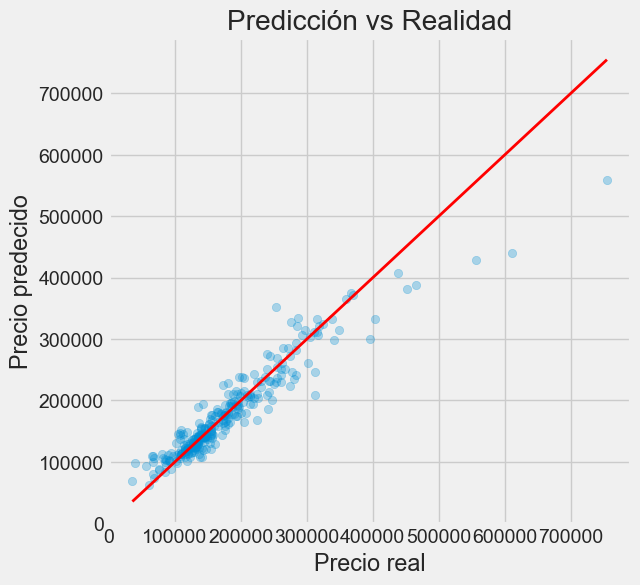

In [93]:


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Precio real")
plt.ylabel("Precio predecido")
plt.title("Predicción vs Realidad")
plt.grid(True)
plt.show()


In [94]:
import joblib

joblib.dump(best_model, 'modelo_optimizado.pkl')
print("Modelo guardado como modelo_optimizado.pkl")


Modelo guardado como modelo_optimizado.pkl


In [95]:
# Cargar nuevos datos
nuevo_df = pd.read_csv('./input/test.csv')

# Predecir (sin SalePrice en ese set)
predicciones = best_model.predict(nuevo_df)

# Guardar resultados
submission = pd.DataFrame({
    'Id': nuevo_df['Id'],
    'SalePrice': predicciones
})
submission.to_csv('submission.csv', index=False)


In [96]:

# Extraer preprocesador y modelo final
model = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessing']

# Obtener nombres de las columnas transformadas
feature_names = preprocessor.get_feature_names_out()

# Obtener importancias
importances = model.feature_importances_

# Combinar en DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Ver top 15
print(feat_imp.head(15))


             Feature  Importance
17  num__OverallQual    0.573567
9     num__GrLivArea    0.134219
6   num__TotalBsmtSF    0.051545
7      num__2ndFlrSF    0.033724
3    num__BsmtFinSF1    0.032855
27  disc__GarageCars    0.022114
1       num__LotArea    0.019968
30     ord__BsmtQual    0.015534
22    disc__FullBath    0.008418
0   num__LotFrontage    0.008391
33  ord__KitchenQual    0.007472
11  num__OpenPorchSF    0.005732
5     num__BsmtUnfSF    0.005104
10   num__WoodDeckSF    0.005050
28    ord__ExterQual    0.004552



---

### 📊 Importancia de las Variables en el Modelo

* Las **importancias de características** indican cuánto contribuye cada variable a las predicciones del modelo.
* Se basan en la **reducción del error** (impureza) a lo largo de todos los árboles del modelo.
* Los valores:

  * Son **relativos** (todas las importancias suman 1).
  * No implican **causalidad**, solo asociación predictiva.
* Una variable con mayor importancia tiene mayor impacto en el resultado del modelo.
* Variables con importancias cercanas a **0** pueden considerarse irrelevantes y podrían eliminarse en futuras optimizaciones.
* En caso de variables categóricas codificadas con **OneHotEncoder**, es útil **agrupar sus importancias** para interpretar el efecto total de la variable original.

---